In [2]:
# import sys
# path to module files
# sys.path.insert(1, '../python_files/') # insert at 1, 0 is the script path (or '' in REPL)

from gate_module import *
import time

In [2]:
# =================================================
# LOADING INITIAL SCENE AND GENERATING TREE DATA
# =================================================

scene = load(filename='astroBoy_walk.dae',file_type='dae')
mesh_id = 3

# scene = load(models/ManosModelc.dae')
# mesh_id = 0

# scene = load('../models/manosModeld.dae')
# mesh_id = 0



In [3]:

mesh = scene.meshes[mesh_id]
v = mesh.vertices
f = mesh.faces
b = mesh.bones
vw = vertex_weight(len(v))
vw.populate(b)


In [4]:
print(len(np.unique(v)))
print(len(f))

print(b[0].offsetmatrix)
print(scene.rootnode.transformation)
print(b[0])
# print(scene.rootnode.children)
print(scene.rootnode.children[0].children)

1261
1118
[[ 0.          0.288277    0.95754701 -2.41152   ]
 [ 0.          0.95754701 -0.288277   -8.01922035]
 [-1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   1.  ]]
astroBoy_newSkeleton_spine01
[]


## EUCLIDEAN WAY

In [5]:
# =================================================
# APPLYING EXTRA TRANSFORMATIONS IN JOINTS
# =================================================

transform = False  
# transform = True

M = initialize_M(b)

# M[1][0:3,0:3] = eulerAnglesToRotationMatrix([0.3,0.3,0.4])
# M[1][0:3,3] = [5,5,5]
# M[1] = np.dot(np.diag([2,2,2,1]),M[1]) 


# =================================================
# EVALUATING NEW VERTICES AFTER SKINNING
# =================================================


MM = read_tree(scene,mesh_id,M,transform)
BB = [b[i].offsetmatrix for i in range(len(b))]
newv = np.zeros([(len(v)),3])


start = time.time()
for i in range(len(v)):
    for j in range(4):
        if vw.id[i][j] >=0:
            mat = np.dot(MM[vw.id[i][j]],BB[vw.id[i][j]])  
            # mat = BB[vw.id[i][j]]           
            newv[i] = newv[i] + vw.weight[i][j]*(vertex_apply_M(v[i],mat))
end = time.time()

# =================================================
# PLOTTING
# =================================================


# USING MESH PLOT OUTSIDE JUPYTER
# mp.offline()

print("TIME : ", end-start)
print("TRANSFORMATION = ", transform)
p = mp.plot(newv, f,newv[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)  
# p.save("skinning.html")


TIME :  0.07947182655334473
TRANSFORMATION =  False


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3864668…

In [6]:
print(b[0])

astroBoy_newSkeleton_spine01


In [2]:
from System_skinning import System_skinning
from skinned_mesh import Skinned_mesh


   
a = Skinned_mesh(filename='/Users/mlbeb/Desktop/boo/internship/py_code/pyECSSTree/pyECSS/examples/astroBoy_walk.dae',file_type='dae')
b = System_skinning()
# a.mesh_id = 3
b.generate_mesh(a.v, a.f, a.b, a.model, a.mesh_id)
    
    

[[ 0.639357 12.1689   -0.893018]
 [ 0.708351 12.0602   -0.499071]
 [ 0.69148  11.8125   -0.601681]
 ...
 [ 0.76853   4.19049   0.16335 ]
 [ 0.758502  4.46014   0.199789]
 [ 0.621837  4.45258   0.124552]]
pipi
TIME :  0.06429409980773926
TRANSFORMATION =  False
col: (2266, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3864668…

## GA WAY

In [16]:
# =================================================
# MULTIVECTORS FOR TRANSFORMATION
# =================================================
transform = True
transform = False

dd = [1 for i in range(len(b))]
tt = [1 for i in range(len(b))]
rr = [1 for i in range(len(b))]


rr[2] = axis_angle_to_rotor([1,2,0],-0.3)
tt[0] = vector_to_translator([0,2,0])
dd[1] = scale_to_dilator(0.5)


# =================================================
# EVALUATING NEW VERTICES AFTER SKINNING
# =================================================

def euc_to_cga_point(v):
    return v[0]*e1+v[1]*e2+v[2]*e3

def cga_to_euc_point(down):
    return np.array([down[e1], down[e2], down[e3]])




rotors = read_tree_ga(scene,mesh_id,tt,rr,dd,transform)
BB = [matrix_to_motor(b[i].offsetmatrix) for i in range(len(b))]
cgav = [up_vertex(vertex) for vertex in v]
newv2 = np.zeros([(len(v)),3])

start = time.time()
for i in range(len(v)):
    for j in range(4):
        if vw.id[i][j] >=0:
            rotor =  (rotors[vw.id[i][j]])*BB[vw.id[i][j]] 
            temp = down_vertex(rotor*cgav[i]*~rotor)
            newv2[i] = newv2[i] + vw.weight[i][j]*temp
end = time.time()

# =================================================
# PLOTTING
# =================================================


print("TIME : ", end-start)
p2 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)
# p.save("2r.html")

TypeError: object of type 'System_skinning' has no len()

In [ ]:
# =================================================
# COMPARISON
# =================================================
print("to kanoniko mesh einai to EUCLIDEAN WAY")
print("ta magenta lines einai to GA WAY")

p3 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 3,"wireframe":True},return_plot=True)

# plotting lines
p3.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
p3.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
p3.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});

# or simply plotting the whole mesh
# p3.add_mesh(newv, f,shading={"scale": 2.6,"wireframe":True,"color": "magenta"})



to kanoniko mesh einai to EUCLIDEAN WAY
ta magenta lines einai to GA WAY


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3864668…

In [ ]:
# =================================================
# SIDE BY SIDE
# =================================================
# print("to kanoniko mesh einai to EUCLIDEAN WAY")
# print("ta magenta lines einai to GA WAY")

p4 = mp.subplot(newv, f,newv[:, 1],shading={"scale": 2,"wireframe":True},s=[1,2,0])
mp.subplot(newv2, f,newv2[:, 1],shading={"scale": 2,"wireframe":True,"wire_color": "magenta"},s=[1,2,1], data=p4)
# plotting lines
# p4.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
# p4.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
# p4.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});

# or simply plotting the whole mesh
# p3.add_mesh(newv, f,shading={"scale": 2.6,"wireframe":True,"color": "magenta"})

# print("Original Way (Left), CGA Way (Right)")

# Comparison Tests for Euclidean and GA Skinning

## TEST CASE 1

We can see the differences in scaling depending on the alpha.

Check the dilator in GA Way: it is chosen to be LERP(d1,d2,alpha)

In [ ]:
################################
#### EUCLIDEAN WAY - START  ####
################################

def test1(alpha,print_plot=False,print_time=False):
    # transform = False  
    transform = True

    M = initialize_M(b)

    # M[1][0:3,0:3] = eulerAnglesToRotationMatrix([0.3,0.3,0.4])
    # M[1][0:3,3] = [5,5,5]
#     M[1] = np.dot(np.diag([2,2,2,1]),M[1])
    scale = LERP(1,2,alpha)
    M[1] = np.dot(np.diag([scale,scale,scale,1]),M[1])


    # =================================================
    # EVALUATING NEW VERTICES AFTER SKINNING
    # =================================================


    MM = read_tree(scene,mesh_id,M,transform)
    BB = [b[i].offsetmatrix for i in range(len(b))]
    newv = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                mat = np.dot(MM[vw.id[i][j]],BB[vw.id[i][j]])            
                newv[i] = newv[i] + vw.weight[i][j]*(vertex_apply_M(v[i],mat))
    end = time.time()
    if print_time:
        print("TIME EUC: ", end-start)
    

    ################################
    ####     GA WAY - START     ####
    ################################
    # =================================================
    # MULTIVECTORS FOR TRANSFORMATION
    # =================================================

    dd = [1 for i in range(len(b))]
    tt = [1 for i in range(len(b))]
    rr = [1 for i in range(len(b))]


    # rr[2] = axis_angle_to_rotor([1,2,0],-0.3)
    # tt[0] = vector_to_translator([0,2,0])
    s1 = 1
    s2 = scale_to_dilator(2)
    dd[1] = LERP(s1,s2,alpha)



    rotors = read_tree_ga(scene,mesh_id,tt,rr,dd,transform)
    BB = [matrix_to_motor(b[i].offsetmatrix) for i in range(len(b))]
    cgav = [up_vertex(vertex) for vertex in v]
    newv2 = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                rotor =  (rotors[vw.id[i][j]])*BB[vw.id[i][j]] 
                temp = down_vertex(rotor*cgav[i]*~rotor)
                newv2[i] = newv2[i] + vw.weight[i][j]*temp
    end = time.time()
    if print_time:
        print("TIME GA : ", end-start)

    

    # =================================================
    # COMPARISON
    # =================================================

    if print_plot:
        print("to kanoniko mesh einai to EUCLIDEAN WAY")
        print("ta magenta lines einai to GA WAY")

        p3 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)

        # plotting lines
        p3.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});

    return numpy.linalg.norm(newv-newv2,numpy.inf)/numpy.linalg.norm(newv,numpy.inf)

test1(1,True,True)


TIME EUC:  0.06642913818359375
TIME GA :  0.21682500839233398
to kanoniko mesh einai to EUCLIDEAN WAY
ta magenta lines einai to GA WAY


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.7361738…

2.8257745786320073e-06

## TEST CASE 2

The differences in scaling can be eradicated if the scaling factor is interpolated instead of the dilator itself.

Check the dilator in GA Way: it is chosen to be d = scale_to_dilator(LERP(1,2,alpha))


In [ ]:
################################
#### EUCLIDEAN WAY - START  ####
################################

def test2(alpha,print_plot=False,print_time=False):
    # transform = False  
    transform = True

    M = initialize_M(b)

    # M[1][0:3,0:3] = eulerAnglesToRotationMatrix([0.3,0.3,0.4])
    # M[1][0:3,3] = [5,5,5]
#     M[1] = np.dot(np.diag([2,2,2,1]),M[1])
    scale = LERP(1,2,alpha)
    M[1] = np.dot(np.diag([scale,scale,scale,1]),M[1])


    # =================================================
    # EVALUATING NEW VERTICES AFTER SKINNING
    # =================================================


    MM = read_tree(scene,mesh_id,M,transform)
    BB = [b[i].offsetmatrix for i in range(len(b))]
    newv = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                mat = np.dot(MM[vw.id[i][j]],BB[vw.id[i][j]])            
                newv[i] = newv[i] + vw.weight[i][j]*(vertex_apply_M(v[i],mat))
    end = time.time()
    if print_time:
        print("TIME EUC: ", end-start)

    ################################
    ####     GA WAY - START     ####
    ################################
    # =================================================
    # MULTIVECTORS FOR TRANSFORMATION
    # =================================================

    dd = [1 for i in range(len(b))]
    tt = [1 for i in range(len(b))]
    rr = [1 for i in range(len(b))]


    # rr[2] = axis_angle_to_rotor([1,2,0],-0.3)
    # tt[0] = vector_to_translator([0,2,0])
    dd[1] = scale_to_dilator(LERP(1,2,alpha))



    rotors = read_tree_ga(scene,mesh_id,tt,rr,dd,transform)
    BB = [matrix_to_motor(b[i].offsetmatrix) for i in range(len(b))]
    cgav = [up_vertex(vertex) for vertex in v]
    newv2 = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                rotor =  (rotors[vw.id[i][j]])*BB[vw.id[i][j]] 
                temp = down_vertex(rotor*cgav[i]*~rotor)
                newv2[i] = newv2[i] + vw.weight[i][j]*temp
    end = time.time()
    if print_time:
        print("TIME GA : ", end-start)


    # =================================================
    # COMPARISON
    # =================================================

    if print_plot:
        print("to kanoniko mesh einai to EUCLIDEAN WAY")
        print("ta magenta lines einai to GA WAY")

        p3 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)

        # plotting lines
        p3.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});



    return numpy.linalg.norm(newv-newv2,numpy.inf)/numpy.linalg.norm(newv,numpy.inf)

test2(0.3,True,True)



TIME EUC:  0.10024809837341309
TIME GA :  0.1956009864807129
to kanoniko mesh einai to EUCLIDEAN WAY
ta magenta lines einai to GA WAY


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4913789…

3.6769814586809205e-06

## TEST CASE 3

Checking translation differences. 

Big differences here due to errors cumulating, especially in complicated models, or if translation is disproportional to model dimensions. 

In [ ]:
################################
#### EUCLIDEAN WAY - START  ####
################################

def test3(alpha,print_plot=False,print_time=False):
    # transform = False  
    transform = True

    M = initialize_M(b)

    # M[1][0:3,0:3] = eulerAnglesToRotationMatrix([0.3,0.3,0.4])

    M[1][0:3,3] = LERP(np.array([0,0,0]),np.array([0,1,0]),alpha)
    
    #M[1] = np.dot(np.diag([2,2,2,1]),M[1])


    # =================================================
    # EVALUATING NEW VERTICES AFTER SKINNING
    # =================================================


    MM = read_tree(scene,mesh_id,M,transform)
    BB = [b[i].offsetmatrix for i in range(len(b))]
    newv = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                mat = np.dot(MM[vw.id[i][j]],BB[vw.id[i][j]])            
                newv[i] = newv[i] + vw.weight[i][j]*(vertex_apply_M(v[i],mat))
    end = time.time()
    if print_time:
        print("TIME EUC: ", end-start)

    ################################
    ####     GA WAY - START     ####
    ################################
    # =================================================
    # MULTIVECTORS FOR TRANSFORMATION
    # =================================================

    dd = [1 for i in range(len(b))]
    tt = [1 for i in range(len(b))]
    rr = [1 for i in range(len(b))]


    # rr[2] = axis_angle_to_rotor([1,2,0],-0.3)
    
    tt[1] = LERP(1,vector_to_translator([0,1,0]),alpha)
    #dd[1] = scale_to_dilator(LERP(1,2,alpha))



    rotors = read_tree_ga(scene,mesh_id,tt,rr,dd,transform)
    BB = [matrix_to_motor(b[i].offsetmatrix) for i in range(len(b))]
    cgav = [up_vertex(vertex) for vertex in v]
    newv2 = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                rotor =  (rotors[vw.id[i][j]])*BB[vw.id[i][j]] 
                temp = down_vertex(rotor*cgav[i]*~rotor)
                newv2[i] = newv2[i] + vw.weight[i][j]*temp
    end = time.time()
    if print_time:
        print("TIME GA : ", end-start)
    # =================================================
    # COMPARISON
    # =================================================

    if print_plot:
        print("to kanoniko mesh einai to EUCLIDEAN WAY")
        print("ta magenta lines einai to GA WAY")

        p3 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)

        # plotting lines
        p3.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});

    return numpy.linalg.norm(newv-newv2,numpy.inf)/numpy.linalg.norm(newv,numpy.inf)

test3(1,True,True)




TIME EUC:  0.09818911552429199
TIME GA :  0.16423606872558594
to kanoniko mesh einai to EUCLIDEAN WAY
ta magenta lines einai to GA WAY


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4163869…

0.010628892173879719

## TEST CASE 4

Checking rotation differences. 


In [ ]:
################################
#### EUCLIDEAN WAY - START  ####
################################
from quaternion import *

def test4(alpha,print_plot=False,print_time=False):
    # transform = False  
    transform = True

    M = initialize_M(b)

    q1 = q2 = Quaternion(0,0,0,1)
    q2 = Quaternion.from_angle_axis(-0.7, [1,2,0])
    q = LERP(q1,q2,alpha)
    
    M[1] = q.to_transformation_matrix()
#     M[1][0:3,0:3] = eulerAnglesToRotationMatrix([0.3,0.3,0.4])
#     M[1][0:3,3] = [0,5,0]
    #M[1] = np.dot(np.diag([2,2,2,1]),M[1])

    
    # =================================================
    # EVALUATING NEW VERTICES AFTER SKINNING
    # =================================================


    MM = read_tree(scene,mesh_id,M,transform)
    BB = [b[i].offsetmatrix for i in range(len(b))]
    newv = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                mat = np.dot(MM[vw.id[i][j]],BB[vw.id[i][j]])            
                newv[i] = newv[i] + vw.weight[i][j]*(vertex_apply_M(v[i],mat))
    end = time.time()
    if print_time:
        print("TIME EUC: ", end-start)

    ################################
    ####     GA WAY - START     ####
    ################################
    # =================================================
    # MULTIVECTORS FOR TRANSFORMATION
    # =================================================

    dd = [1 for i in range(len(b))]
    tt = [1 for i in range(len(b))]
    rr = [1 for i in range(len(b))]

    r1 = 1
    r2 = axis_angle_to_rotor([1,2,0],-0.7)
    rr[1] = LERP(r1,r2,alpha)
    
#     tt[1] = vector_to_translator([0,5,0])
    #dd[1] = scale_to_dilator(LERP(1,2,alpha))



    rotors = read_tree_ga(scene,mesh_id,tt,rr,dd,transform)
    BB = [matrix_to_motor(b[i].offsetmatrix) for i in range(len(b))]
    cgav = [up_vertex(vertex) for vertex in v]
    newv2 = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                rotor =  (rotors[vw.id[i][j]])*BB[vw.id[i][j]] 
                temp = down_vertex(rotor*cgav[i]*~rotor)
                newv2[i] = newv2[i] + vw.weight[i][j]*temp
    end = time.time()
    if print_time:
        print("TIME GA : ", end-start)
    # =================================================
    # COMPARISON
    # =================================================


    if print_plot:
        print("to kanoniko mesh einai to EUCLIDEAN WAY")
        print("ta magenta lines einai to GA WAY")

        p3 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)

        # plotting lines
        p3.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});


    
    return numpy.linalg.norm(newv-newv2,numpy.inf)/numpy.linalg.norm(newv,numpy.inf)

test4(0.5,True,True)



TIME EUC:  0.1515209674835205
TIME GA :  0.3624870777130127
to kanoniko mesh einai to EUCLIDEAN WAY
ta magenta lines einai to GA WAY


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.2137213…

0.002927079169941471

## Test Case 5

This is a failed attempt to remedy test case 3 results, by downprojecting only once per vertex in GA way, see lines 64-70. It is obvious that the runtime for GA gets larger since we are forced to add multivectors (of dimension 32) instead of points (of dimension 3) during the double nested for. The rel. error is the same as in case 3. 

In [ ]:
################################
#### EUCLIDEAN WAY - START  ####
################################

def test5(alpha,print_plot=False,print_time=False):
    # transform = False  
    transform = True

    M = initialize_M(b)

    # M[1][0:3,0:3] = eulerAnglesToRotationMatrix([0.3,0.3,0.4])

    M[1][0:3,3] = LERP(np.array([0,0,0]),np.array([0,5,0]),alpha)
    
    #M[1] = np.dot(np.diag([2,2,2,1]),M[1])


    # =================================================
    # EVALUATING NEW VERTICES AFTER SKINNING
    # =================================================


    MM = read_tree(scene,mesh_id,M,transform)
    BB = [b[i].offsetmatrix for i in range(len(b))]
    newv = np.zeros([(len(v)),3])

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                mat = np.dot(MM[vw.id[i][j]],BB[vw.id[i][j]])            
                newv[i] = newv[i] + vw.weight[i][j]*(vertex_apply_M(v[i],mat))
    end = time.time()
    if print_time:
        print("TIME EUC: ", end-start)

    ################################
    ####     GA WAY - START     ####
    ################################
    # =================================================
    # MULTIVECTORS FOR TRANSFORMATION
    # =================================================

    dd = [1 for i in range(len(b))]
    tt = [1 for i in range(len(b))]
    rr = [1 for i in range(len(b))]


    # rr[2] = axis_angle_to_rotor([1,2,0],-0.3)
    
    tt[1] = LERP(1,vector_to_translator([0,5,0]),alpha)
    #dd[1] = scale_to_dilator(LERP(1,2,alpha))



    rotors = read_tree_ga(scene,mesh_id,tt,rr,dd,transform)
    BB = [matrix_to_motor(b[i].offsetmatrix) for i in range(len(b))]
    cgav = [up_vertex(vertex) for vertex in v]
    newv2 = np.zeros([(len(v)),3])
    newv2_up = [0 for vertex in v]

    start = time.time()
    for i in range(len(v)):
        for j in range(4):
            if vw.id[i][j] >=0:
                rotor =  (rotors[vw.id[i][j]])*BB[vw.id[i][j]] 
#                 temp = down_vertex(rotor*cgav[i]*~rotor)
                temp = rotor*cgav[i]*~rotor
                newv2_up[i] = newv2_up[i] + vw.weight[i][j]*temp
        newv2[i] = down_vertex(newv2_up[i])
    end = time.time()
    if print_time:
        print("TIME GA : ", end-start)
    # =================================================
    # COMPARISON
    # =================================================

    if print_plot:
        print("to kanoniko mesh einai to EUCLIDEAN WAY")
        print("ta magenta lines einai to GA WAY")

        p3 = mp.plot(newv2, f,newv2[:, 1],shading={"scale": 2.5,"wireframe":True},return_plot=True)

        # plotting lines
        p3.add_lines(newv[f[:,0]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,1]], shading={"line_color": "magenta"});
        p3.add_lines(newv[f[:,2]], newv[f[:,0]], shading={"line_color": "magenta"});

    return numpy.linalg.norm(newv-newv2,numpy.inf)/numpy.linalg.norm(newv,numpy.inf)

test5(1)





0.04161929308289945

## Tables with relative errors for each method

Results for test case 1,2,3,4: 
* 1st column is alpha, 
* 2nd column is relative error (showing percentage) between EUC and GA produced vertices, counting EUC way as the correct ones, using norm 1 as the measure function

In [ ]:
test1_results = [test1(i/10) for i in range(11)]
for i in range(11):
    alpha = i/10
    print(alpha, '\t', test1_results[i])
#     print(alpha, '\t', test1(alpha))

0.0 	 4.22204002891107e-06
0.1 	 0.014612657038193208
0.2 	 0.025695942226601275
0.3 	 0.03346995769659467
0.4 	 0.03808373687687193
0.5 	 0.03962265475450756
0.6 	 0.038112535443822385
0.7 	 0.033520838734778284
0.8 	 0.025755030917939577
0.9 	 0.014657988698468306
1.0 	 2.8257745786320073e-06


In [ ]:
test2_results = [test2(i/10) for i in range(11)]
for i in range(11):
    alpha = i/10
    print(alpha, '\t', test2_results[i])
#     print(alpha, '\t', test2(alpha))

0.0 	 4.22204002891107e-06
0.1 	 4.023244372733938e-06
0.2 	 3.842327559259874e-06
0.3 	 3.6769814586809205e-06
0.4 	 3.5252788507099793e-06
0.5 	 3.3855979613580454e-06
0.6 	 3.256564256277673e-06
0.7 	 3.137005055854935e-06
0.8 	 3.0259137936394655e-06
0.9 	 2.9224216093651065e-06
1.0 	 2.8257745786320073e-06


In [ ]:
test3_results = [test3(i/10) for i in range(11)]
for i in range(11):
    alpha = i/10
    print(alpha, '\t', test3_results[i])
#     print(alpha, '\t', test3(alpha))

0.0 	 4.22204002891107e-06
0.1 	 0.001120804726632861
0.2 	 0.0022306483192702123
0.3 	 0.003329934585195308
0.4 	 0.00441881345028811
0.5 	 0.0054974320150216706
0.6 	 0.0065590584133283355
0.7 	 0.007598096018888732
0.8 	 0.008622545533124961
0.9 	 0.009632712039643651
1.0 	 0.010628892173879719


In [ ]:
test4_results = [test4(i/10) for i in range(11)]
for i in range(11):
    alpha = i/10
    print(alpha, '\t', test4_results[i])
#     print(alpha, '\t', test4(alpha))

0.0 	 4.22204002891107e-06
0.1 	 0.00022671206481437493
0.2 	 0.0007957367003126482
0.3 	 0.001540920920544986
0.4 	 0.0023027113588615653
0.5 	 0.002927079169941471
0.6 	 0.003276643709387887
0.7 	 0.0033190275311313694
0.8 	 0.0028676290141709847
0.9 	 0.0017976357828561208
1.0 	 4.1049762850074885e-06


In [ ]:
test5_results = [test5(i/10) for i in range(11)]
for i in range(11):
    alpha = i/10
    print(alpha, '\t', test5_results[i])
#     print(alpha, '\t', test5(alpha))

0.0 	 0.00012202313197082494
0.1 	 0.005497910828305997
0.2 	 0.01062937813568995
0.3 	 0.015410315752034342
0.4 	 0.019881707611642863
0.5 	 0.024072673709150557
0.6 	 0.028008792540258485
0.7 	 0.03171262360050045
0.8 	 0.035204140030422826
0.9 	 0.03850108893227044
1.0 	 0.04161929308289945


Text(0, 0.5, 'errors for test4')

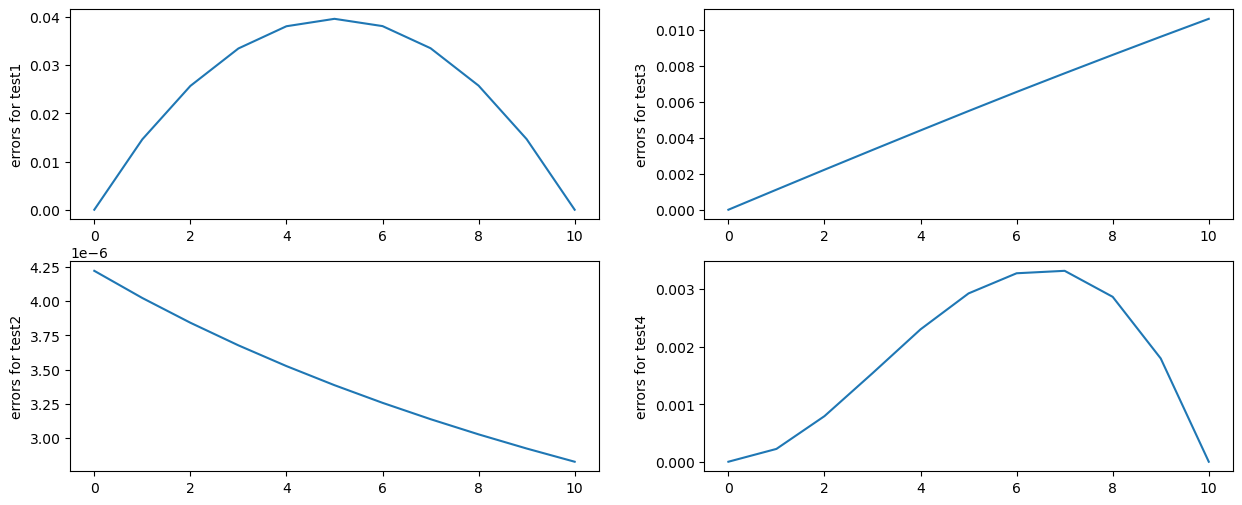

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(221)
ax.plot(range(11),test1_results)
ax.set_ylabel('errors for test1')

ax2 = fig.add_subplot(223)
ax2.plot(range(11),test2_results)
ax2.set_ylabel('errors for test2')

ax3 = fig.add_subplot(222)
ax3.plot(range(11),test3_results)
ax3.set_ylabel('errors for test3')


ax4 = fig.add_subplot(224)
ax4.plot(range(11),test4_results)
ax4.set_ylabel('errors for test4')

# plt.show()



## Dilations differences between multivector and original

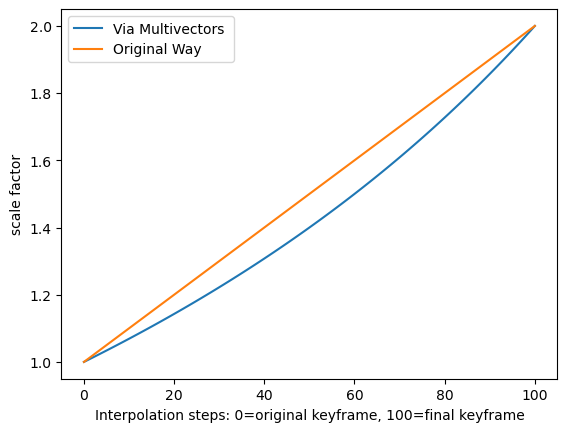

megisto sfalma: 0.1010204081632653


In [ ]:
def dilator_to_scale(m):
    n = m[e45] # e45 = einf^eo
    return (1-n)/(1+n)

steps = 100

d1 = scale_to_dilator(1)
d2 = scale_to_dilator(2)
test_d_interpolation_results = [dilator_to_scale( (1-i/steps)*d1+(i/steps)*d2) for i in range(steps+1)]
# for i in range(11):
#     alpha = i/10
#     print(alpha, '\t', test3_results[i])
#     print(alpha, '\t', test3(alpha))

import matplotlib.pyplot as plt
plt.figure()

plt.plot(range(steps+1),test_d_interpolation_results)
correct = [1 + i/steps for i in range(steps+1)] 
plt.plot(range(steps+1),correct)

plt.ylabel('scale factor')
plt.xlabel('Interpolation steps: 0=original keyframe, 100=final keyframe')
# txt="Interpolation steps: 0=original keyframe, 100=final keyframe"
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.legend(('Via Multivectors ', 'Original Way'))

plt.show()

diff = [correct[i]-test_d_interpolation_results[i] for i in range(len(correct))]
print('megisto sfalma:',numpy.linalg.norm(diff,numpy.inf))
